# 理解した気持ちになるガウス過程

機械学習チーム・上間

## ガウス過程のうわさ

* 過学習しない
* ハイパーパラメータのチューニング不要
* ランダムフォレスト等のハイパーパラメータ探索に使われる
* 予測値だけでなく信頼度(?)も得られる
* 無限の隠れユニットを持つ深層学習と等価

結局, 理解しないと使いどころがわからない...

## どうしたら理解した気持ちになるか

* 式を導出
* 実装
* 実際の問題に適用

式を導出するだけでなく, 実装したりいじったりすｒことで,使いどころが分かる気がする

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## 単純な回帰を考えてみる

* 式 $y_i = \sin(x_{i,1}) + \cos(x_{i,2}) + \epsilon$ に基づく $\boldsymbol{y}$ がある
* $\boldsymbol{x_i}$ だけが観測されたとして, これらデータから $\boldsymbol{y}$ を求めたい
* $\epsilon$ はガウス分布に基づくノイズ

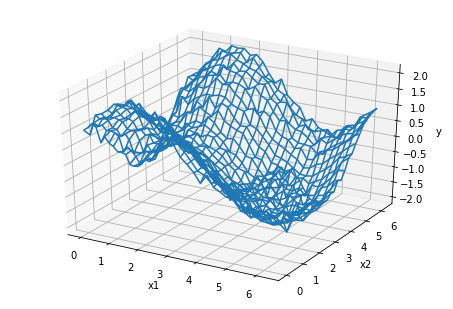

In [18]:
N = 30
x1, x2 = np.meshgrid(np.linspace(0, 2*np.pi, N), np.linspace(0, 2*np.pi, N))
y = (np.sin(x1.ravel())+np.cos(x2.ravel())+np.random.normal(0,0.1,x1.ravel().shape[0])).reshape(x1.shape)

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_wireframe(x1, x2, y)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("y")
plt.show()

## 問題を定式化する

* まず, $\boldsymbol{x_i} = (x_{i,1}, x_{i,2})$ とおく.
    * より一般化すると $\boldsymbol{x_i}$ は $(1, D)$ のベクトル
    * $\boldsymbol{X}$は $(N, D)$ の行列
    * $N$ はサンプル数, $D$ は入力の次元数
 
 
    
* つぎに, この $\boldsymbol{X}$ を $\boldsymbol{y}$ に変換してくれる関数を $f(\boldsymbol{X}) = \boldsymbol{Xw^T}$ とおく. 
    * $\boldsymbol{w} \sim N(\boldsymbol{0,\Sigma})$ と仮定する
    * $\boldsymbol{w}$は $(1, D)$ のベクトル
    * ちなみに $\boldsymbol{y}$ が $M$ 次元なら $(M, D)$ のベクトル


* ただし, $\boldsymbol{y}$ にはガウスノイズが乗っていると仮定し, それを $\epsilon$ で表す
    * $\epsilon \sim N(0, \sigma^2_n)$ 
    * 入力 $\boldsymbol{X}$ とは独立に定まる


* よって $\boldsymbol{X}$ と $\boldsymbol{y}$ の関係は $\boldsymbol{y}=f(\boldsymbol{X})+\boldsymbol{\epsilon}$ となる.
    * $\boldsymbol{y}$は(N, 1)のベクトル
    * $y_i$はスカラー

## ガウス過程について

### ところでガウス過程とは

*確率過程 $\{X_t\}_t∈T$ は、任意に（有限個の）$X_{t1}, ..., X_{tk}$ を選んで作った線型結合（あるいはより一般に、$\{X_t\}_t∈T$ を標本関数 X_t 全体からなる連続濃度の函数空間と見たときの、任意の線型汎関数）が正規分布に従うとき、ガウス過程という。*

引用 https://ja.wikipedia.org/wiki/%E3%82%AC%E3%82%A6%E3%82%B9%E9%81%8E%E7%A8%8B

* 確率過程 ... *時間とともに変化する確率変数*
* a ∈ A ... *Aの集合の要素がa*

### なるほど！わからん...

翻訳すると
ガウス過程とは, 任意の $X_{t1}, ..., X_{tk}$ の線型結合が正規分布に従うこと

今回は

$\boldsymbol{w} \sim N(\boldsymbol{0,\Sigma})$

なので,正規分布の再生性より, 

$y_i=f(\boldsymbol{x_i})+\boldsymbol{\epsilon} = \boldsymbol{x_iw^T}+\boldsymbol{\epsilon} = x_1w_1+...+x_Dw_D + \epsilon$ 

は正規分布に基づく
* 正規分布の再生性とは, 正規分布に正規分布を足したり, 定数をかけたりしても正規分布であるとい性質
* https://to-kei.net/distribution/normal-distribution/nature/

よって, 今回の問題はガウス過程となる(たぶん...)

## で, 結局ガウス過程だったら何が嬉しいの? 

**$\boldsymbol{y}$ のとりうる値(事後分布)解析的に求められる!**


観測 $\boldsymbol{X}$ が得られたとき, $\boldsymbol{y}$ を取る確率 = 事後分布 を求めたい

$\boldsymbol{y_i}$ は独立であり, 正規分布に基づくので,

$$
\begin{align*}
p(\boldsymbol{y}|\boldsymbol{X},\boldsymbol{w}) &= p(y_1|\boldsymbol{x_1},\boldsymbol{w}) \times p(y_2|\boldsymbol{x_2},\boldsymbol{w}) \times ... \times p(y_N|\boldsymbol{x_N},\boldsymbol{w})\\
&= \prod_{i=1}^N p(y_i|\boldsymbol{x_i},\boldsymbol{w})\\
&= \prod_{i=1}^N N(y_i|\boldsymbol{x_iw^T},\sigma^2)\\
&= \prod_{i=1}^N \frac{1}{\sqrt{2\pi\sigma^2}} \exp{\left(\frac{-(y_i-\boldsymbol{x_i}\boldsymbol{w^T})^2}{2\sigma^2}\right)}\\
&= \left(\frac{1}{\sqrt{2\pi\sigma^2}}\right)^N \prod_{i=1}^N \exp{\left(\frac{-(y_i-\boldsymbol{x_i}\boldsymbol{w^T})^2}{2\sigma^2}\right)}\\
&= \left(\frac{1}{\sqrt{2\pi\sigma^2}}\right)^N \exp{\left( \sum_{i=1}^N \frac{-(y_i-\boldsymbol{x_i}\boldsymbol{w^T})^2}{2\sigma^2}\right)}\\
&= \left(\frac{1}{\sqrt{2\pi\sigma^2}}\right)^N \exp{\left\{-\frac{1}{2\sigma^2} \left((y_1-\boldsymbol{x_1}\boldsymbol{w^T})^2+...+(y_N-\boldsymbol{x_N}\boldsymbol{w^T})^2\right) \right\}}\\
\end{align*}
$$

ここで, ベクトル $\boldsymbol{a}=(\begin{array}{cccc} a_1 & a_2 & ... &a_N \end{array} )$ のL2ノルムは $\|\boldsymbol{a}\| = \sqrt{a_1^2+a_2^2+...+a_N^2}$ なので

$a_1^2+a_2^2+...+a_N^2 = \|\boldsymbol{a}\|^2 = \|(\begin{array}{cccc} a_1 & a_2 & ... &a_N \end{array})\|^2$ とおいて

$$
\begin{align*}
p(\boldsymbol{y}|\boldsymbol{X},\boldsymbol{w}) &= \left(\frac{1}{\sqrt{2\pi\sigma^2}}\right)^N \exp{\left\{-\frac{1}{2\sigma^2} \|\left(\begin{array}{ccc}y_1-\boldsymbol{x_1}\boldsymbol{w^T}&...&y_N-\boldsymbol{x_N}\boldsymbol{w^T}\end{array}\right)\|^2 \right\}}\\
&= \left(\frac{1}{\sqrt{2\pi\sigma^2}}\right)^N \exp{\left\{-\frac{1}{2\sigma^2} \|(\begin{array}{ccc}y_1&...&y_N\end{array}) - (\begin{array}{ccc}\boldsymbol{x_1}\boldsymbol{w^T}&...&\boldsymbol{x_N}\boldsymbol{w^T}\end{array})\|^2 \right\}}\\
&= \left(\frac{1}{\sqrt{2\pi\sigma^2}}\right)^N \exp{\left\{-\frac{1}{2\sigma^2} \|\boldsymbol{y^T} - \boldsymbol{w}(\begin{array}{ccc}\boldsymbol{x_1^T}&...&\boldsymbol{x_N^T}\end{array})\|^2 \right\}}\\
&= \left(\frac{1}{\sqrt{2\pi\sigma^2}}\right)^N \exp{\left\{-\frac{1}{2\sigma^2} \|\boldsymbol{y^T} - \boldsymbol{w}\boldsymbol{X^T}\|^2 \right\}}
\end{align*}
$$

また, $\|\boldsymbol{a}\|^2=a_1^2+a_2^2+...+a_N^2 = \boldsymbol{a}\boldsymbol{a^T}$ と表せるので

$$
\begin{align*}
p(\boldsymbol{y}|\boldsymbol{X},\boldsymbol{w}) &= \left(\frac{1}{\sqrt{2\pi\sigma^2}}\right)^N \exp{\left\{-\frac{1}{2\sigma^2} \left(\boldsymbol{y^T} - \boldsymbol{w}\boldsymbol{X^T}\right)\left(\boldsymbol{y^T} - \boldsymbol{w}\boldsymbol{X^T}\right)^T \right\}}\\
&= \left(\frac{1}{\sqrt{2\pi\sigma^2}}\right)^N \exp{\left\{-\frac{1}{2\sigma^2} \left(\boldsymbol{y} - \boldsymbol{X}\boldsymbol{w^T}\right)^T\left(\boldsymbol{y} - \boldsymbol{X}\boldsymbol{w^T}\right) \right\}}\\
&= \left(\frac{1}{\left(\sqrt{2\pi}\right)^N\sqrt{|\sigma^2\boldsymbol{I}|}}\right) \exp{\left\{ -\frac{1}{2} \left(\boldsymbol{y} - \boldsymbol{X}\boldsymbol{w^T}\right)^T \left(\sigma^2 \boldsymbol{I} \right)^{-1} \left(\boldsymbol{y} - \boldsymbol{X}\boldsymbol{w^T}\right) \right\}}
\end{align*}
$$

よって,$\boldsymbol{y}$ の事後分布は平均$\boldsymbol{X}\boldsymbol{w^T}$ 分散$\sigma^2\boldsymbol{I}$ の多次元ガウス分布となる!

これはつまり,同時分布 $p(\boldsymbol{y}) = p(y_1,...,y_N)$ が多次元ガウス分布に従うことを意味する.

ちなみに多次元ガウス分布は以下の式で表せる

$$
N(\boldsymbol{x}|\boldsymbol{\mu},\boldsymbol{\Sigma}) = \frac{1}{\left(\sqrt{2\pi}\right)^N\sqrt{|\boldsymbol{\Sigma}|}}\exp{\left\{-\frac{1}{2}(\boldsymbol{x}-\boldsymbol{\mu})^T \Sigma^{-1} (\boldsymbol{x}-\boldsymbol{\mu})\right\}}
$$

ここで, パラメータ$\boldsymbol{w}$を求めたい

$\boldsymbol{w} \sim N(0,\Sigma)$

ベイズの定理より

\begin{align*}
p(\boldsymbol{w}|\boldsymbol{X},\boldsymbol{y}) &= \frac{p(\boldsymbol{y}|\boldsymbol{X},\boldsymbol{w})p(\boldsymbol{w})}{p(\boldsymbol{X},\boldsymbol{y})}\\
&\propto p(\boldsymbol{y}|\boldsymbol{X},\boldsymbol{w})p(\boldsymbol{w})\\
&= \left(\frac{1}{\left(\sqrt{2\pi}\right)^N\sqrt{|\sigma^2\boldsymbol{I}|}}\right) \exp{\left\{ -\frac{1}{2} \left(\boldsymbol{y} - \boldsymbol{Xw^T}\right)^T \left(\sigma^2 \boldsymbol{I} \right)^{-1} \left(\boldsymbol{y} - \boldsymbol{Xw^T}\right) \right\}} \left(\frac{1}{\left(\sqrt{2\pi}\right)^D\sqrt{|\boldsymbol{\Sigma}|}}\right) \exp{\left(-\frac{1}{2} \boldsymbol{w\Sigma^{-1}w^T} \right)}\\
&\propto \exp{\left\{ -\frac{1}{2} \left(\boldsymbol{y} - \boldsymbol{Xw^T}\right)^T \left(\sigma^2 \boldsymbol{I} \right)^{-1} \left(\boldsymbol{y} - \boldsymbol{Xw^T}\right) \right\} \exp{\left(-\frac{1}{2} \boldsymbol{w\Sigma^{-1}w^T} \right)}}\\
&= \exp{\left\{ -\frac{1}{2} \left( \left( \boldsymbol{y} - \boldsymbol{X}\boldsymbol{w^T}\right)^T \left(\sigma^2 \boldsymbol{I} \right)^{-1} \left(\boldsymbol{y} - \boldsymbol{Xw^T}\right)+\boldsymbol{w\Sigma^{-1}w^T} \right) \right\} }\\
&= \exp{\left\{ -\frac{1}{2} \left( \frac{1}{\sigma^2}\left( \boldsymbol{y} - \boldsymbol{Xw^T}\right)^T \left(\boldsymbol{y} - \boldsymbol{Xw^T}\right)+\boldsymbol{w\Sigma^{-1}w^T} \right) \right\} }\\
&= \exp{\left\{ -\frac{1}{2} \left( \frac{1}{\sigma^2} \left( \boldsymbol{y^T} - \boldsymbol{wX^T}\right) \left(\boldsymbol{y} - \boldsymbol{Xw^T}\right)+\boldsymbol{w\Sigma^{-1}w^T} \right) \right\} }\\
&= \exp{\left\{ -\frac{1}{2} \left( \frac{1}{\sigma^2} \left( \boldsymbol{y^T} - \boldsymbol{wX^T}\right)\boldsymbol{y} - \left( \boldsymbol{y^T} - \boldsymbol{wX^T}\right) \boldsymbol{Xw^T} +\boldsymbol{w\Sigma^{-1}w^T} \right) \right\} }\\
&= \exp{\left\{ -\frac{1}{2} \left( \frac{1}{\sigma^2} \left(\boldsymbol{y^Ty}-\boldsymbol{wX^Ty}-\boldsymbol{y^TXw^T}+\boldsymbol{wX^TXw^T}\right) +\boldsymbol{w\Sigma^{-1}w^T} \right) \right\} }\\
&= \exp{\left\{ -\frac{1}{2} \left( \frac{1}{\sigma^2} \left(\boldsymbol{y^Ty}-\boldsymbol{wX^Ty}-\boldsymbol{y^TXw^T}\right)+ \frac{1}{\sigma^2}\boldsymbol{wX^TXw^T}+\boldsymbol{w\Sigma^{-1}w^T} \right) \right\} }\\
&= \exp{\left\{ -\frac{1}{2} \left( \boldsymbol{w} \left( \frac{1}{\sigma^2}\boldsymbol{X^TX}+\boldsymbol{\Sigma^{-1}} \right) \boldsymbol{w^T}-\frac{1}{\sigma^2}\left(\boldsymbol{wX^Ty}+\boldsymbol{y^TXw^T}\right)+\frac{1}{\sigma^2}\boldsymbol{y^Ty} \right) \right\}}
\end{align*}

ここで

$\boldsymbol{A}=\boldsymbol{A^T}=\frac{1}{\sigma^2}\boldsymbol{X^TX}+\boldsymbol{\Sigma}^{-1}$

$\boldsymbol{b}=\frac{1}{\sigma^2}\boldsymbol{X^Ty}$

$c=\frac{1}{\sigma^2}\boldsymbol{y^Ty}$

とおくと

\begin{align*}
p(\boldsymbol{w}|\boldsymbol{X},\boldsymbol{y}) 
&= \exp{\left\{ -\frac{1}{2} \left( \boldsymbol{wAw^T}-\boldsymbol{wb}-\boldsymbol{b^Tw^T}+c \right) \right\}}\\
&= \exp{\left\{ -\frac{1}{2} \left( \boldsymbol{wAw^T}-\boldsymbol{wb}-\boldsymbol{b^Tw^T} +\boldsymbol{b^TA^{-1}b}-\boldsymbol{b^TA^{-1}b} +c \right) \right\}}\\
&= \exp{\left\{ -\frac{1}{2} \left( \left(\boldsymbol{wA}-\boldsymbol{b^T}\right)\boldsymbol{w^T} - \left(\boldsymbol{w}-\boldsymbol{b^TA^{-1}}\right)\boldsymbol{b} -\boldsymbol{b^TA^{-1}b} +c \right) \right\}}\\
&= \exp{\left\{ -\frac{1}{2} \left( \left(\boldsymbol{wA}-\boldsymbol{b^T}\right)\boldsymbol{w^T} - \left(\boldsymbol{wAA^{-1}}-\boldsymbol{b^TA^{-1}}\right)\boldsymbol{b} -\boldsymbol{b^TA^{-1}b} +c \right) \right\}}\\
&= \exp{\left\{ -\frac{1}{2} \left( \left(\boldsymbol{wA}-\boldsymbol{b^T}\right)\boldsymbol{w^T} - \left(\boldsymbol{wA}-\boldsymbol{b^T}\right)\boldsymbol{A^{-1}b} -\boldsymbol{b^TA^{-1}b} +c \right) \right\}}\\
&= \exp{\left\{ -\frac{1}{2} \left( \left(\boldsymbol{wA}-\boldsymbol{b^T}\right)\left(\boldsymbol{w^T} - \boldsymbol{A^{-1}b}\right) -\boldsymbol{b^TA^{-1}b} +c \right) \right\}}\\
&= \exp{\left\{ -\frac{1}{2} \left( \left(\boldsymbol{w}-\boldsymbol{b^TA^{-1}}\right)\boldsymbol{A}\left(\boldsymbol{w^T} - \boldsymbol{A^{-1}b}\right) -\boldsymbol{b^TA^{-1}b} +c \right) \right\}}\\
&= \exp{\left\{ -\frac{1}{2} \left( \left(\boldsymbol{w^T}-\boldsymbol{A^{-1}b}\right)^T\boldsymbol{A}\left(\boldsymbol{w^T} - \boldsymbol{A^{-1}b}\right) -\boldsymbol{b^TA^{-1}b} +c \right) \right\}}\\
&= \exp{\left\{ -\frac{1}{2} \left( \boldsymbol{w^T}-\boldsymbol{A^{-1}b}\right)^T\boldsymbol{A}\left(\boldsymbol{w^T} - \boldsymbol{A^{-1}b}\right)\right\}}\exp{\left\{-\frac{1}{2} \left(c-\boldsymbol{b^TA^{-1}b}\right)\right\}}\\
&\propto \exp{\left\{ -\frac{1}{2} \left( \boldsymbol{w^T}-\boldsymbol{A^{-1}b}\right)^T\boldsymbol{(A^{-1})^{-1}}\left(\boldsymbol{w^T} - \boldsymbol{A^{-1}b}\right)\right\}}
\end{align*}

従って $\boldsymbol{w}$ の事後分布は,

平均 $\overline{\boldsymbol{w^T}} = E[\boldsymbol{w^T}] = \boldsymbol{A^{-1}b} = \left(\frac{1}{\sigma^2}\boldsymbol{X^TX}+\boldsymbol{\Sigma}^{-1}\right)^{-1} \frac{1}{\sigma^2}\boldsymbol{X^Ty} = \frac{1}{\sigma^2}\boldsymbol{A^{-1}X^Ty}$ 

分散  $\overline{\boldsymbol{v}} = V[\boldsymbol{w}] = \boldsymbol{A^{-1}} = \left(\frac{1}{\sigma^2}\boldsymbol{X^TX}+\boldsymbol{\Sigma}^{-1}\right)^{-1}$

の多次元ガウス分布に従う

## 予測する

パラメータ $w$ のとりうる値が得られて嬉しいかもしれないが, 
結局のところやりたいのは新しく得られた値の予測

新しく得られた観測データを $\hat{x}$ とする(ただし $(1, D)$ のベクトル)

### 予測の期待値を求める

ここで, $f(\boldsymbol{\hat{x}})$ がとりうる期待値$E[f(\boldsymbol{\hat{x}})]$は

$$
E[f(\boldsymbol{\hat{x}})] = E[\boldsymbol{\hat{x}w^T}]
$$ 

$\boldsymbol{\hat{x}}$ は定数なので, 

$$
E[f(\boldsymbol{\hat{x}})] = \boldsymbol{\hat{x}}E[\boldsymbol{w^T}] = \boldsymbol{\hat{x}}\overline{\boldsymbol{w^T}} 
= \boldsymbol{\hat{x}} \frac{1}{\sigma^2}\boldsymbol{A^{-1}X^Ty}
$$

ここで

$$
\begin{align*}
\boldsymbol{A} & = \boldsymbol{A^T}=\frac{1}{\sigma^2}\boldsymbol{X^TX}+\boldsymbol{\Sigma}^{-1} \\
\boldsymbol{A\Sigma} &= \frac{1}{\sigma^2}\boldsymbol{X^TX\Sigma}+\boldsymbol{I}\\
\boldsymbol{A\Sigma X^T} &= \frac{1}{\sigma^2}\boldsymbol{X^TX\Sigma X^T}+\boldsymbol{X^T}
= \frac{1}{\sigma^2}\boldsymbol{X^T} \left( \boldsymbol{X\Sigma X^T}+\sigma^2\boldsymbol{I} \right) \\
\boldsymbol{\Sigma X^T} &= \frac{1}{\sigma^2}\boldsymbol{A^{-1}X^T} \left( \boldsymbol{X\Sigma X^T}+\sigma^2\boldsymbol{I} \right) \\
\boldsymbol{\Sigma X^T}\left( \boldsymbol{X\Sigma X^T}+\sigma^2\boldsymbol{I} \right)^{-1} &= \frac{1}{\sigma^2}\boldsymbol{A^{-1}X^T}  \\
\frac{1}{\sigma^2}\boldsymbol{A^{-1}X^T} &= \boldsymbol{\Sigma X^T}\left( \boldsymbol{X\Sigma X^T}+\sigma^2\boldsymbol{I} \right)^{-1}\\
\end{align*}
$$

となる. これを代入すると, 
新しく得られた $\boldsymbol{\hat{x}}$ の予測(つまり, 期待値)は,

$$
E[f(\boldsymbol{\hat{x}})] = \boldsymbol{\hat{x}} \boldsymbol{\Sigma X^T}\left( \boldsymbol{X\Sigma X^T}+\sigma^2\boldsymbol{I} \right)^{-1}\boldsymbol{y}
$$

なぜこんな式変形をしたかというと, 後ほど触れるカーネル法のため

### 予測の分散を求める

また, 分散 $V[f(\boldsymbol{\hat{x}})]$ は

$$
\begin{align*}
V[f(\boldsymbol{\hat{x}})] &= E \left[ \left(f(\boldsymbol{\hat{x}})-\overline{f(\boldsymbol{\hat{x}})} \right) \left(f(\boldsymbol{\hat{x}})-\overline{f(\boldsymbol{\hat{x}})} \right)^T \right] \\
&= E \left[ \left(f(\boldsymbol{\hat{x}})-E[f(\boldsymbol{\hat{x}})] \right) \left(f(\boldsymbol{\hat{x}})-E[f(\boldsymbol{\hat{x}})] \right)^T \right]\\
&= E \left[ \left(\boldsymbol{\hat{x}w^T}-\boldsymbol{\hat{x}\overline{w^T}} \right) \left(\boldsymbol{\hat{x}w^T}-\boldsymbol{\hat{x}\overline{w^T}} \right)^T \right]\\
&= E \left[ \boldsymbol{\hat{x}}\left(\boldsymbol{w^T}-\boldsymbol{\overline{w^T}} \right) \left\{ \boldsymbol{\hat{x}^T}\left(\boldsymbol{w^T}-\boldsymbol{\overline{w^T}} \right) \right\}^T \right] \\
&= E \left[ \boldsymbol{\hat{x}}\left(\boldsymbol{w^T}-\boldsymbol{\overline{w^T}} \right) \left(\boldsymbol{w^T}-\boldsymbol{\overline{w^T}}\right)^T\boldsymbol{\hat{x}^T} \right] \\
&= \boldsymbol{\hat{x}}E\left[\left(\boldsymbol{w^T}-\boldsymbol{\overline{w^T}} \right) \left(\boldsymbol{w^T}-\boldsymbol{\overline{w^T}}\right)^T \right]\boldsymbol{\hat{x}^T} \\
&= \boldsymbol{\hat{x}V[w]\hat{x}^T}\\
&= \boldsymbol{\hat{x}A^{-1}\hat{x}^T}
\end{align*}
$$

ここで, 逆行列の補題より, 

$$
\begin{align*}
\boldsymbol{\left(Z+UWV^T \right)^{-1} = Z^{-1} - Z^{-1}U\left(W^{-1}+V^TZ^{-1}U\right)^{-1}V^TZ^{-1}}
\end{align*}
$$


$\boldsymbol{Z^{-1}=\Sigma}, \boldsymbol{W^{-1}}=\sigma^2\boldsymbol{I}, \boldsymbol{V=U=X^T}$ とおくと,

右辺は

$$
\begin{align*}
\boldsymbol{\left(Z+UWV^T \right)^{-1}} =& \boldsymbol{\left(\Sigma^{-1}+X^T \frac{1}{\sigma^2}\boldsymbol{I} X \right)^{-1}}\\ 
=& \left(\frac{1}{\sigma^2}\boldsymbol{X^T X+\Sigma^{-1}}\right)^{-1}\\
=& A^{-1}
\end{align*}
$$

左辺は

$$
\begin{align*}
\boldsymbol{Z^{-1} - Z^{-1}U\left(W^{-1}+V^TZ^{-1}U\right)^{-1}V^TZ^{-1}} &= 
\boldsymbol{\Sigma^{-1}} - \boldsymbol{\Sigma^{-1}X^T}\left(\sigma^2\boldsymbol{I}+\boldsymbol{X\Sigma X^T}\right)^{-1}\boldsymbol{X\Sigma^{-1}} 
\end{align*}
$$

まとめると

$$
\begin{align*}
A^{-1} = \boldsymbol{\Sigma^{-1}} - \boldsymbol{\Sigma^{-1}X^T}\left(\sigma^2\boldsymbol{I}+\boldsymbol{X\Sigma X^T}\right)^{-1}\boldsymbol{X\Sigma^{-1}} 
\end{align*}
$$

よって予測値の分散は

$$
\begin{align*}
V[f(\boldsymbol{\hat{x}})] &= \boldsymbol{\hat{x}A^{-1}\hat{x}^T} \\
&= \boldsymbol{\hat{x}}\left(\boldsymbol{\Sigma^{-1}} - \boldsymbol{\Sigma^{-1}X^T}\left(\sigma^2\boldsymbol{I}+\boldsymbol{X\Sigma X^T}\right)^{-1}\boldsymbol{X\Sigma^{-1}}  \right)\boldsymbol{\hat{x}^T} \\
&= \boldsymbol{\hat{x}\Sigma^{-1}\hat{x}^T} - \boldsymbol{\hat{x}}\left(\boldsymbol{\Sigma^{-1}X^T}\left(\sigma^2\boldsymbol{I}+\boldsymbol{X\Sigma X^T}\right)^{-1}\boldsymbol{X\Sigma^{-1}}  \right)\boldsymbol{\hat{x}^T}
\end{align*}
$$

## 実際に予測してみる

## うまくいかない理由
* 線形だから
* 非線形なら?